In [2]:
from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output

clear_output()

In [3]:
model = LanguageModel("microsoft/phi-1_5") # Load the model

# Achtung

Bei den folgenden Zellen kann es zu einem Fehler kommen.
Bei einem Fehler bitte die Zelle einzeln erneut ausführen.
Dies sollte den Fehler umgehen.

Weiteres zu diesem Fehler, sowie mögliche Kontaktwege sind nochmals genauer in der readme.md-Datei beschrieben.

In [12]:
prompt = "Mevlana’nın ünlü eseri Mesnevi" # Define the prompt
layers = model.model.layers # Get the model's layers
probs_layers = [] # Initialize a list to store the probabilities of each token in each layer


# Iterate over each layer and compute the probabilities of each token
with model.trace() as tracer: 
    with tracer.invoke(prompt) as invoker:
        for layer_idx, layer in enumerate(layers):
            # Process layer output through the model's head and layer normalization
            layer_output = model.lm_head(model.model.final_layernorm(layer.output[0]))

            # Compute the probabilities of each token
            probs = torch.nn.functional.softmax(layer_output, dim=-1).save()
            probs_layers.append(probs)

# Concatenate the probabilities of each token in each layer
probs = torch.cat([probs.value for probs in probs_layers])

# Find the maximum probability and corresponding tokens for each position
max_probs, tokens = probs.max(dim=-1)


# Decode token IDs to words for each layer
words = [[model.tokenizer.decode(t.tolist()).encode("unicode_escape").decode() for t in layer_tokens]
    for layer_tokens in tokens]

# Access the 'input_ids' attribute of the invoker object to get the input words
input_words = [model.tokenizer.decode(t) for t in invoker.inputs[0]["input_ids"][0]]

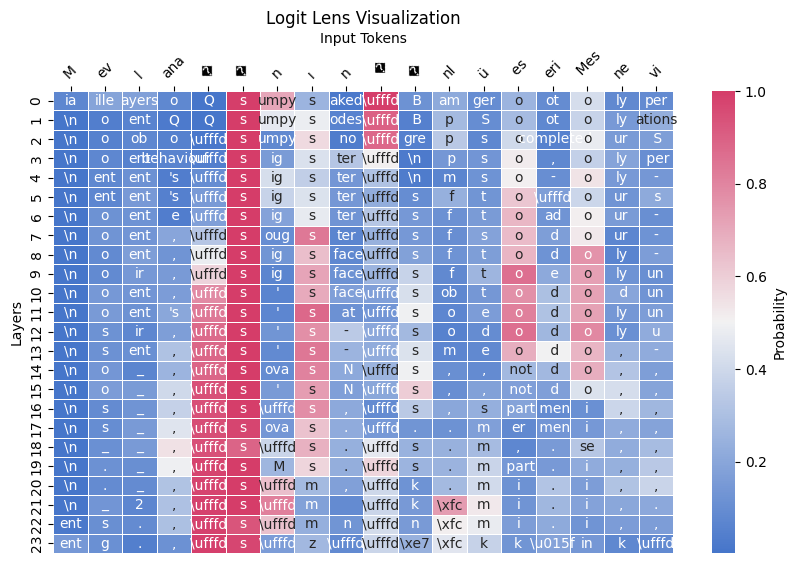

In [13]:
output_words = input_words[1:] + ["?"] # Define the output words

# Create a diverging color palette
cmap = sns.diverging_palette(255, 0, n=len(words[0]), as_cmap=True)

# Plot the logit lens visualization
plt.figure(figsize=(10, 6))
ax=sns.heatmap(max_probs.cpu().detach().numpy(), annot=np.array(words), fmt='', cmap=cmap, linewidths=.5, cbar_kws={'label': 'Probability'})

# Set the plot labels
plt.title('Logit Lens Visualization')
plt.xlabel('Input Tokens')
plt.ylabel('Layers')

# Set the ticks
plt.yticks(np.arange(len(words)) + 0.5, range(len(words)))

# Set the x-axis ticks
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position("top")
plt.xticks(np.arange(len(input_words)) + 0.5, input_words, rotation=45)
plt.show()
